In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch_geometric
import torch_geometric.datasets.ogb_mag as ogb_mag
from torch_geometric.data import HeteroData
print("Current working directory:", os.getcwd())
import torch

Current working directory: c:\Users\gabri\GTFO_Onedrive\DTU_Code\GraphSSL


In [3]:
# Load the OGB-MAG dataset
print("Current working directory:", os.getcwd())
print("\nLoading OGB-MAG dataset...")

# Define data path relative to the workspace folder
data_path = os.path.join('data')
os.makedirs(data_path, exist_ok=True)

# Load dataset
dataset = ogb_mag.OGB_MAG(root=data_path)
data = dataset[0]  # Get the heterogeneous graph data

print(f"\nDataset loaded successfully!")
print(f"Data saved in: {os.path.abspath(data_path)}")

Current working directory: c:\Users\gabri\GTFO_Onedrive\DTU_Code\GraphSSL

Loading OGB-MAG dataset...


Processing...
Done!



Dataset loaded successfully!
Data saved in: c:\Users\gabri\GTFO_Onedrive\DTU_Code\GraphSSL\data


In [4]:
# Exploratory Data Analysis - Basic Structure
print("="*80)
print("OGB-MAG DATASET OVERVIEW")
print("="*80)

print(f"\nDataset: {dataset}")
print(f"\nNumber of graphs: {len(dataset)}")
print("number of classes:\t\t",dataset.num_classes)
print("number of node features:\t",dataset.num_node_features) # Each paper is associated with a 128-dimensional word2vec feature vector
print("number of edge features:\t",dataset.num_edge_features)
print(f"\nHeterogeneous Graph Data:")
print(data)

OGB-MAG DATASET OVERVIEW

Dataset: ogbn-mag()

Number of graphs: 1
number of classes:		 349
number of node features:	 {'paper': 128, 'author': 0, 'institution': 0, 'field_of_study': 0}
number of edge features:	 {('author', 'affiliated_with', 'institution'): 0, ('author', 'writes', 'paper'): 0, ('paper', 'cites', 'paper'): 0, ('paper', 'has_topic', 'field_of_study'): 0}

Heterogeneous Graph Data:
HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ num_nodes=1134649 },
  institution={ num_nodes=8740 },
  field_of_study={ num_nodes=59965 },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)


In [5]:
# Node Types and Counts
print("\n" + "="*80)
print("NODE TYPES AND STATISTICS")
print("="*80)

for node_type in data.node_types:
    print(f"\nNode Type: '{node_type}'")
    if hasattr(data[node_type], 'num_nodes'):
        print(f"  Number of nodes: {data[node_type].num_nodes:,}")
    if hasattr(data[node_type], 'x') and data[node_type].x is not None:
        print(f"  Feature dimension: {data[node_type].x.shape[1]}")
        print(f"  Feature shape: {data[node_type].x.shape}")
    if hasattr(data[node_type], 'y') and data[node_type].y is not None:
        print(f"  Has labels: Yes")
        print(f"  Label shape: {data[node_type].y.shape}")
        print(f"  Number of unique labels: {data[node_type].y.unique().shape[0]}")
        print(f"  Label range: [{data[node_type].y.min()}, {data[node_type].y.max()}]")


NODE TYPES AND STATISTICS

Node Type: 'paper'
  Number of nodes: 736,389
  Feature dimension: 128
  Feature shape: torch.Size([736389, 128])
  Has labels: Yes
  Label shape: torch.Size([736389])
  Number of unique labels: 349
  Label range: [0, 348]

Node Type: 'author'
  Number of nodes: 1,134,649

Node Type: 'institution'
  Number of nodes: 8,740

Node Type: 'field_of_study'
  Number of nodes: 59,965


In [6]:
# Edge Types and Counts
print("\n" + "="*80)
print("EDGE TYPES AND STATISTICS")
print("="*80)

for edge_type in data.edge_types:
    print(f"\nEdge Type: {edge_type}")
    edge_index = data[edge_type].edge_index
    print(f"  Number of edges: {edge_index.shape[1]:,}")
    print(f"  Edge index shape: {edge_index.shape}")
    print(f"  Source node type: '{edge_type[0]}'")
    print(f"  Relation: '{edge_type[1]}'")
    print(f"  Target node type: '{edge_type[2]}'")


EDGE TYPES AND STATISTICS

Edge Type: ('author', 'affiliated_with', 'institution')
  Number of edges: 1,043,998
  Edge index shape: torch.Size([2, 1043998])
  Source node type: 'author'
  Relation: 'affiliated_with'
  Target node type: 'institution'

Edge Type: ('author', 'writes', 'paper')
  Number of edges: 7,145,660
  Edge index shape: torch.Size([2, 7145660])
  Source node type: 'author'
  Relation: 'writes'
  Target node type: 'paper'

Edge Type: ('paper', 'cites', 'paper')
  Number of edges: 5,416,271
  Edge index shape: torch.Size([2, 5416271])
  Source node type: 'paper'
  Relation: 'cites'
  Target node type: 'paper'

Edge Type: ('paper', 'has_topic', 'field_of_study')
  Number of edges: 7,505,078
  Edge index shape: torch.Size([2, 7505078])
  Source node type: 'paper'
  Relation: 'has_topic'
  Target node type: 'field_of_study'


In [7]:
# Paper Node Analysis (Target for Venue Prediction)
print("\n" + "="*80)
print("PAPER NODE ANALYSIS (TARGET FOR VENUE PREDICTION)")
print("="*80)

paper_data = data['paper']

print(f"\nTotal number of papers: {paper_data.num_nodes:,}")
print(f"\nPaper features:")
print(f"  Feature matrix shape: {paper_data.x.shape}")
print(f"  Feature dimension: {paper_data.x.shape[1]}")
print(f"  Data type: {paper_data.x.dtype}")

print(f"\nVenue labels (target variable):")
print(f"  Label shape: {paper_data.y.shape}")
print(f"  Number of unique venues: {paper_data.y.unique().shape[0]}")
print(f"  Venue IDs range: [{paper_data.y.min().item()}, {paper_data.y.max().item()}]")

# Check for train/val/test splits if available
if hasattr(paper_data, 'train_mask'):
    print(f"\nTrain/Val/Test splits:")
    print(f"  Train samples: {paper_data.train_mask.sum().item():,}")
    print(f"  Val samples: {paper_data.val_mask.sum().item():,}")
    print(f"  Test samples: {paper_data.test_mask.sum().item():,}")


PAPER NODE ANALYSIS (TARGET FOR VENUE PREDICTION)

Total number of papers: 736,389

Paper features:
  Feature matrix shape: torch.Size([736389, 128])
  Feature dimension: 128
  Data type: torch.float32

Venue labels (target variable):
  Label shape: torch.Size([736389])
  Number of unique venues: 349
  Venue IDs range: [0, 348]

Train/Val/Test splits:
  Train samples: 629,571
  Val samples: 64,879
  Test samples: 41,939


In [8]:
# Venue Distribution Analysis
print("\n" + "="*80)
print("VENUE DISTRIBUTION")
print("="*80)

venues, counts = np.unique(paper_data.y.cpu().numpy(), return_counts=True)

print(f"\nVenue statistics:")
print(f"  Total venues: {len(venues)}")
print(f"  Mean papers per venue: {counts.mean():.2f}")
print(f"  Median papers per venue: {np.median(counts):.2f}")
print(f"  Min papers per venue: {counts.min()}")
print(f"  Max papers per venue: {counts.max()}")
print(f"  Std papers per venue: {counts.std():.2f}")

print(f"\nTop 10 most common venues:")
top_indices = np.argsort(counts)[-10:][::-1]
for idx in top_indices:
    print(f"  Venue {venues[idx]}: {counts[idx]:,} papers")


VENUE DISTRIBUTION

Venue statistics:
  Total venues: 349
  Mean papers per venue: 2110.00
  Median papers per venue: 842.00
  Min papers per venue: 200
  Max papers per venue: 30902
  Std papers per venue: 3981.18

Top 10 most common venues:
  Venue 1: 30,902 papers
  Venue 134: 30,671 papers
  Venue 300: 27,542 papers
  Venue 258: 24,804 papers
  Venue 283: 24,463 papers
  Venue 281: 18,637 papers
  Venue 311: 16,836 papers
  Venue 189: 15,564 papers
  Venue 9: 14,910 papers
  Venue 193: 12,534 papers


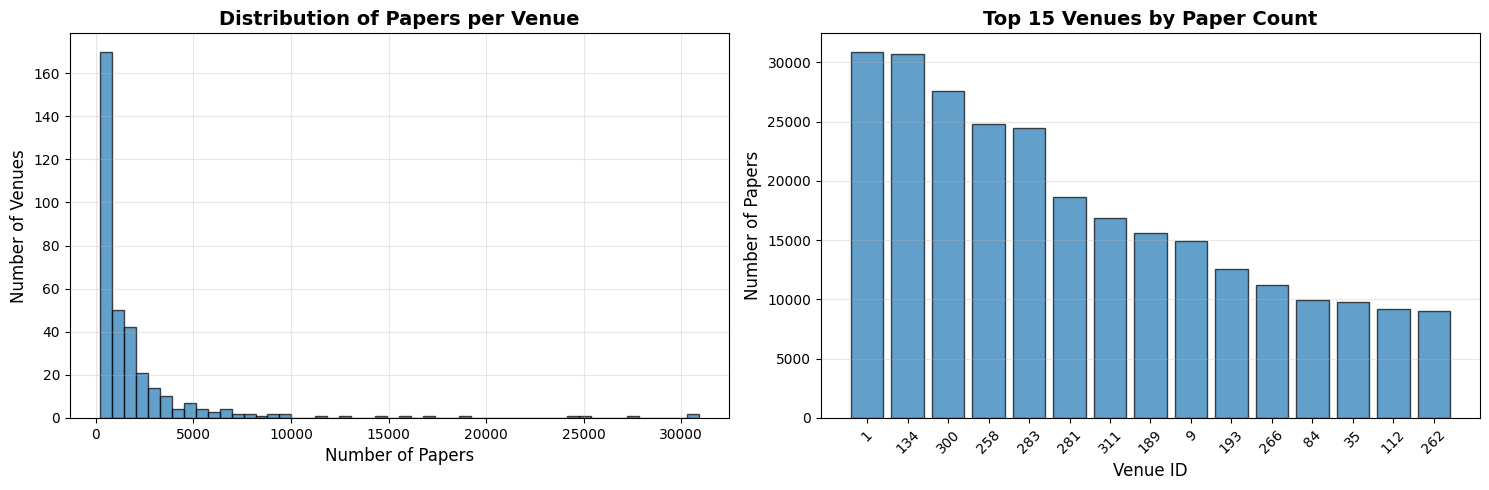

In [9]:
# Visualize Venue Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of papers per venue
axes[0].hist(counts, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Papers', fontsize=12)
axes[0].set_ylabel('Number of Venues', fontsize=12)
axes[0].set_title('Distribution of Papers per Venue', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Bar plot of top 15 venues
top_15_indices = np.argsort(counts)[-15:][::-1]
top_15_venues = venues[top_15_indices]
top_15_counts = counts[top_15_indices]

axes[1].bar(range(len(top_15_venues)), top_15_counts, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Venue ID', fontsize=12)
axes[1].set_ylabel('Number of Papers', fontsize=12)
axes[1].set_title('Top 15 Venues by Paper Count', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(top_15_venues)))
axes[1].set_xticklabels(top_15_venues, rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [10]:
# Graph Connectivity Analysis
print("\n" + "="*80)
print("GRAPH CONNECTIVITY ANALYSIS")
print("="*80)

# Count edges by type
total_edges = 0
for edge_type in data.edge_types:
    num_edges = data[edge_type].edge_index.shape[1]
    total_edges += num_edges

print(f"\nTotal edges in graph: {total_edges:,}")

# Paper-centric edges (important for GraphSAGE on papers)
print(f"\nPaper-related edge types:")
for edge_type in data.edge_types:
    if 'paper' in edge_type[0] or 'paper' in edge_type[2]:
        num_edges = data[edge_type].edge_index.shape[1]
        print(f"  {edge_type}: {num_edges:,} edges")


GRAPH CONNECTIVITY ANALYSIS

Total edges in graph: 21,111,007

Paper-related edge types:
  ('author', 'writes', 'paper'): 7,145,660 edges
  ('paper', 'cites', 'paper'): 5,416,271 edges
  ('paper', 'has_topic', 'field_of_study'): 7,505,078 edges


In [11]:
# Feature Statistics
print("\n" + "="*80)
print("PAPER FEATURE STATISTICS")
print("="*80)

paper_features = paper_data.x.cpu().numpy() # All language embeddings

print(f"\nFeature matrix statistics:")
print(f"  Shape: {paper_features.shape}")
print(f"  Mean: {paper_features.mean():.4f}")
print(f"  Std: {paper_features.std():.4f}")
print(f"  Min: {paper_features.min():.4f}")
print(f"  Max: {paper_features.max():.4f}")
print(f"  Sparsity: {(paper_features == 0).sum() / paper_features.size * 100:.2f}%")

# Check if features are normalized
print(f"\nFeature normalization check:")
print(f"  Per-sample L2 norm (first 5 papers): {np.linalg.norm(paper_features[:5], axis=1)}")


PAPER FEATURE STATISTICS

Feature matrix statistics:
  Shape: (736389, 128)
  Mean: 0.0103
  Std: 0.2318
  Min: -1.4392
  Max: 1.6966
  Sparsity: 0.00%

Feature normalization check:
  Per-sample L2 norm (first 5 papers): [2.5667613 2.5268283 2.723143  2.4478917 2.2559977]


In [14]:
data

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ num_nodes=1134649 },
  institution={ num_nodes=8740 },
  field_of_study={ num_nodes=59965 },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] }
)